In [166]:
import sys
import os
from os import path
import time
from time import sleep

import tensorflow as tf
import numpy as np
import cv2
# import matplotlib.pyplot as plt
import pylab as plt

from tqdm import tqdm, trange, tqdm_notebook, tnrange
import glob
import time
import pandas as pd
import h5py
import pickle as pkl
import subprocess as sp

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Config

In [176]:
slim_dir = "/mnt/workspace/models/research/slim/"
sys.path.insert(0, slim_dir)
from nets import vgg
image_size = vgg.vgg_16.default_image_size
# print(image_size)

dataset_dir = "/mnt/workspace/datasets/UCF-101/"
label_dir = "/mnt/workspace/datasets/ucf101/ucf24/labels/"
batch_size = 16
checkpoints_dir = "/mnt/workspace/models/checkpoints/"

## Define graph 

In [184]:
slim = tf.contrib.slim

with tf.Graph().as_default():
    input_batch = tf.placeholder(dtype=tf.uint8, shape=(batch_size,320,240,3))
    # print(input_batch)
    resized_images = tf.image.resize_images(tf.image.convert_image_dtype(input_batch, dtype=tf.float32),
                                            [image_size,image_size]) # resize to default vgg size
    # print(resized_images)
    normalized_images = tf.multiply(tf.subtract(resized_images, 0.5), 2.0) #normalise from {0,1} to {-1,1}
    # print(normalized_images)
    with slim.arg_scope(vgg.vgg_arg_scope()):
        outputs, end_points = vgg.vgg_16(normalized_images,num_classes=1001, is_training=False)
        final_conv = end_points['vgg_16/conv5/conv5_3']
        fc7 = end_points['vgg_16/fc7']
        print(fc7)
    init_fn = slim.assign_from_checkpoint_fn(os.path.join(checkpoints_dir, 'vgg_16.ckpt'),slim.get_model_variables('vgg_16'))

Tensor("vgg_16/fc7/Relu:0", shape=(16, 1, 1, 4096), dtype=float32)


## Read data and extract features

In [ ]:
def get_frames()

In [44]:
labels = [x.replace(label_dir,"") for x in sorted(glob.glob(label_dir+"*"))]
print(labels)

['Basketball', 'BasketballDunk', 'Biking', 'CliffDiving', 'CricketBowling', 'Diving', 'Fencing', 'FloorGymnastics', 'GolfSwing', 'HorseRiding', 'IceDancing', 'LongJump', 'PoleVault', 'RopeClimbing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Surfing', 'TennisSwing', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog']


In [58]:
from IPython.display import clear_output
# with tqdm(total=len(labels)) as outer_pbar:
#     for category in labels:
#         all_videos = sorted(glob.glob(dataset_dir+category+"/*"))
#         with tqdm(total=len(all_videos)) as inner_pbar:
#             for video in all_videos:
#                 inner_pbar.set_description("Category Progress")
#                 inner_pbar.update(1)
#         clear_output()
#         outer_pbar.set_description("Total progress")
#         outer_pbar.update(1)
#     #     print(all_videos)

for i in tnrange(len(labels), desc='Total progress'):
    all_videos = sorted(glob.glob(dataset_dir+labels[i]+"/*"))
    for j in tnrange(len(all_videos), desc=labels[i], leave=False):
        video_path = all_videos[j]
        

In [173]:
command = [ 'ffmpeg',
            '-i', '/mnt/workspace/datasets/UCF-101/BasketballDunk/v_BasketballDunk_g01_c01.avi',
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)
video_frames = []
while True:
    # read 420*360*3 bytes (= 1 frame)
    raw_image = pipe.stdout.read(240*320*3)
    if len(raw_image) != 240*320*3:
        break;
    # transform the byte read into a numpy array
    image =  np.fromstring(raw_image, dtype='uint8')
    image = image.reshape((240,320,3))
    video_frames.append(image)
    # throw away the data in the pipe's buffer.
    pipe.stdout.flush()
#     np.shape(image)
#     plt.imshow(image)
video_frames = np.asarray(video_frames, dtype=np.float32)

/home/shakthi/miniconda3/envs/ebrnn/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


/home/shakthi/miniconda3/envs/ebrnn/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


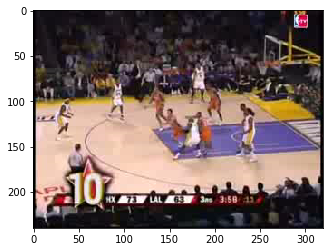

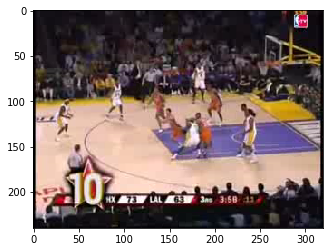

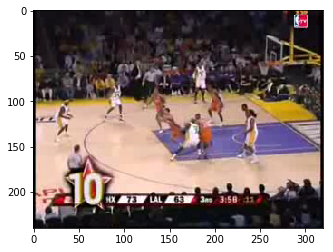

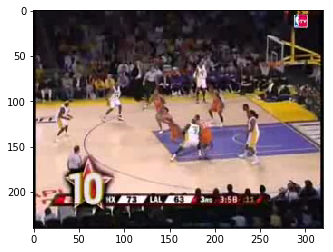

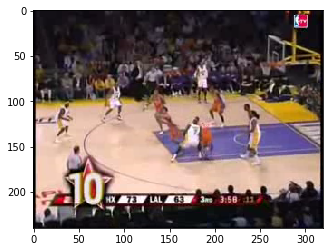

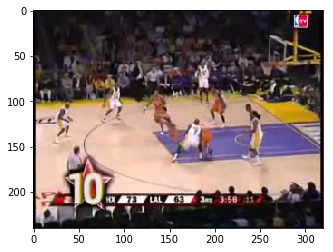

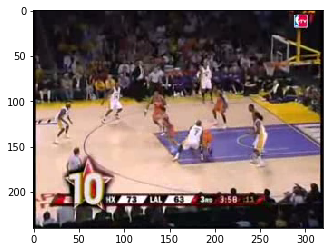

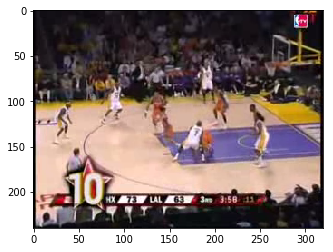

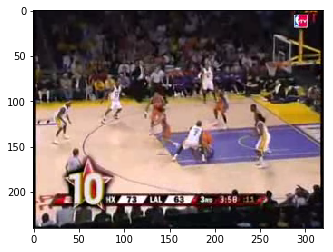

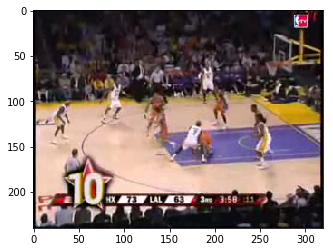

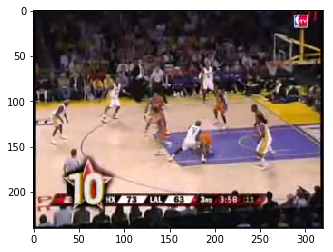

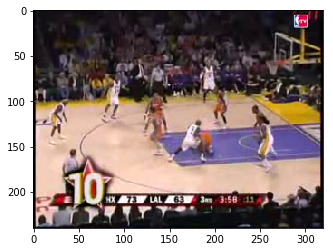

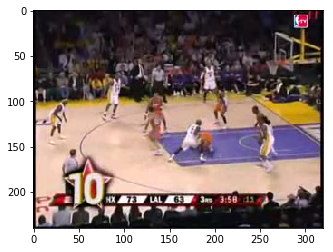

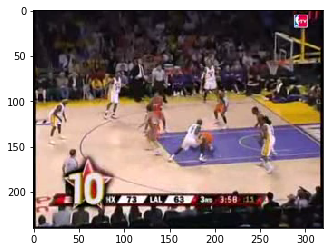

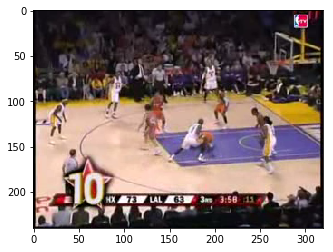

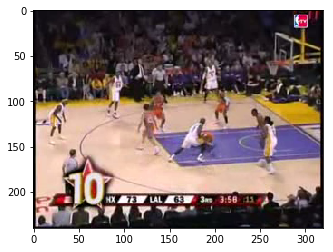

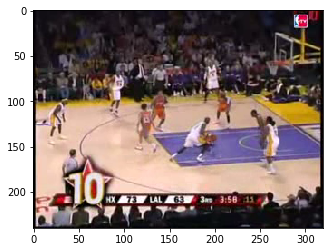

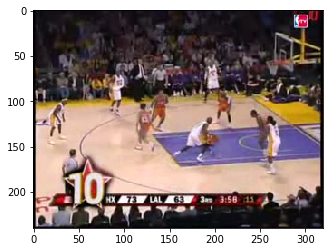

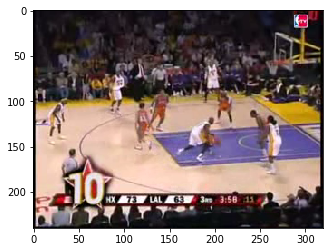

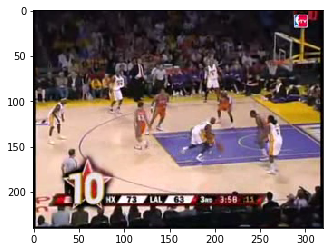

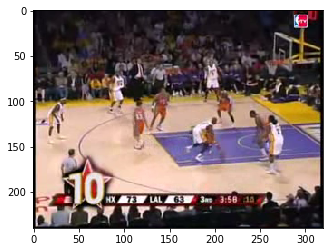

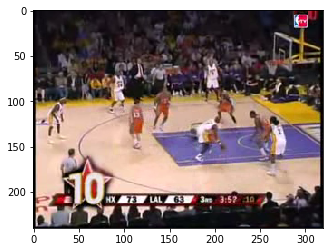

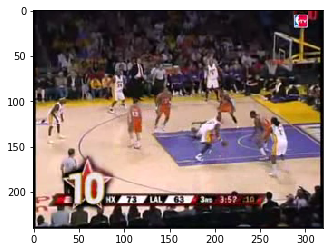

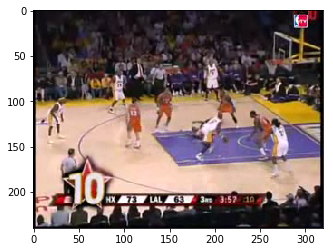

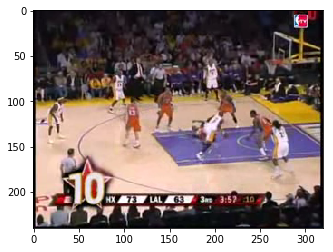

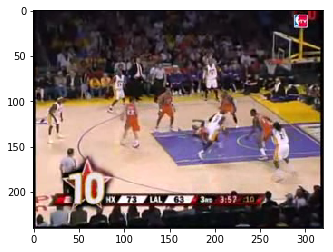

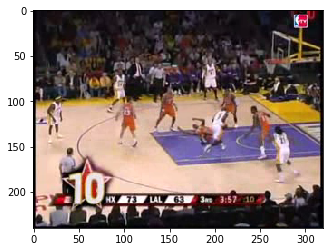

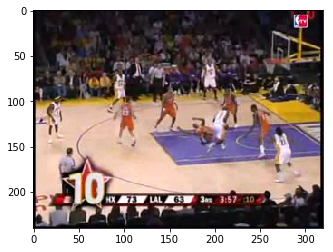

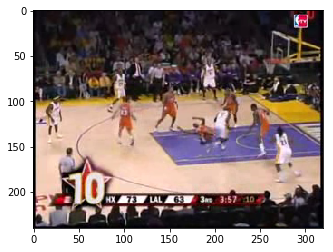

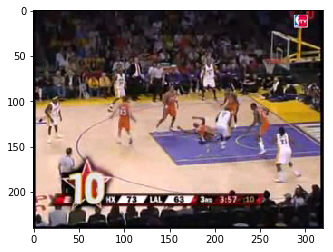

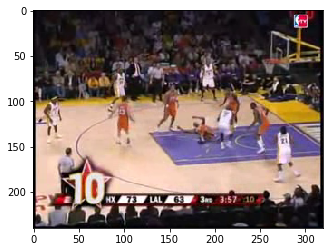

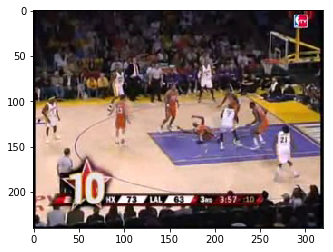

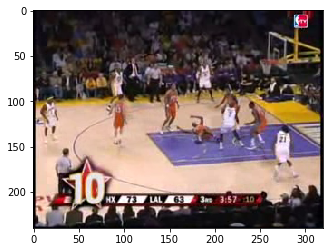

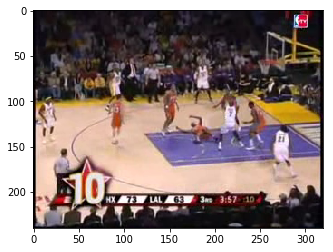

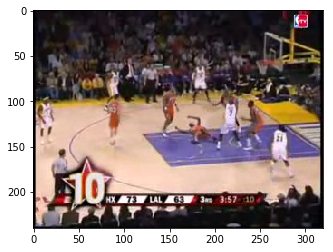

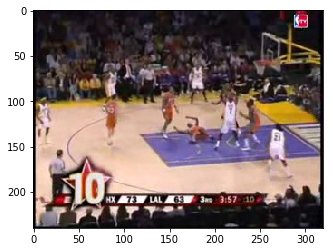

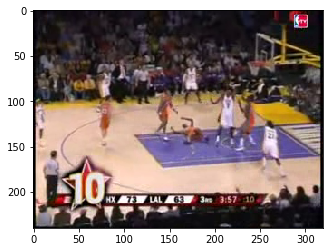

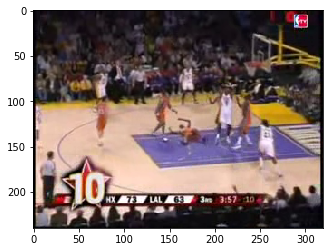

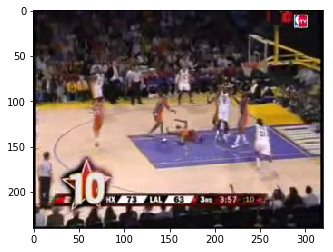

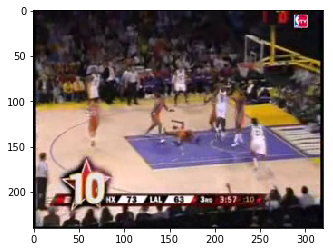

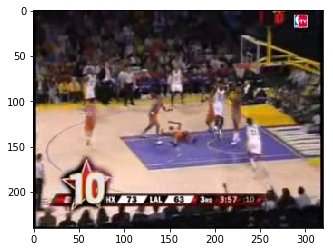

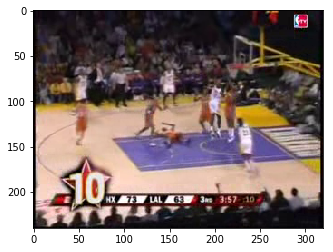

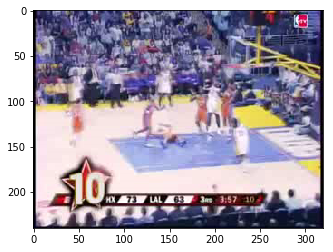

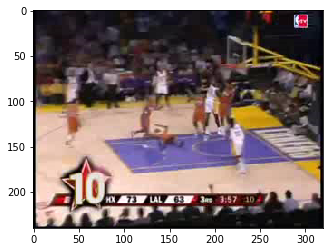

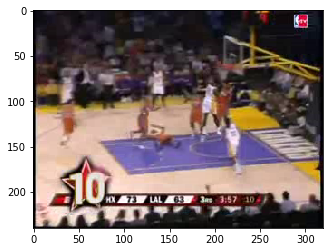

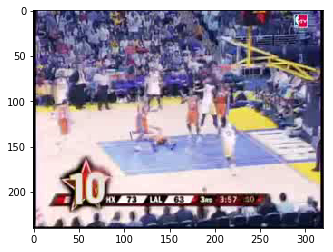

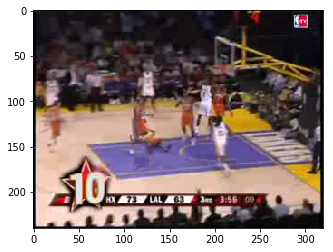

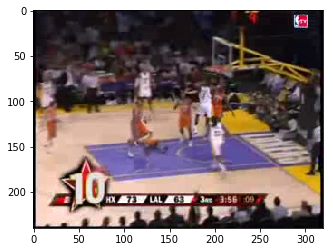

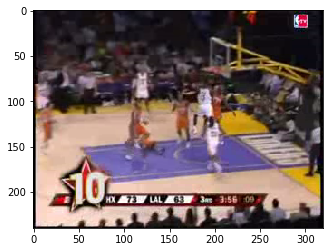

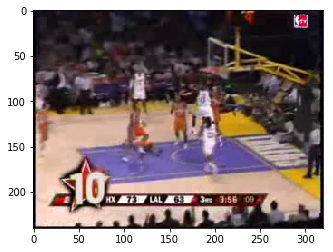

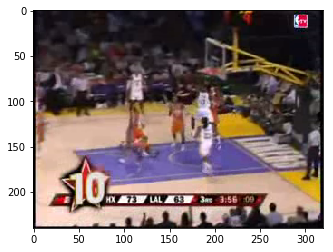

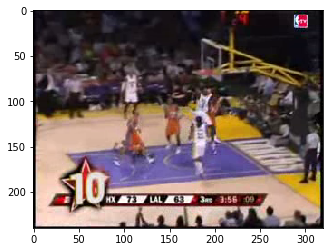

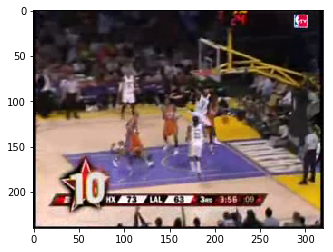

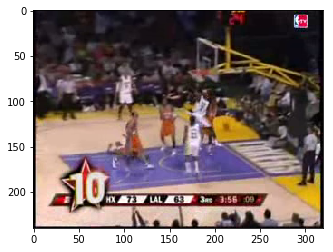

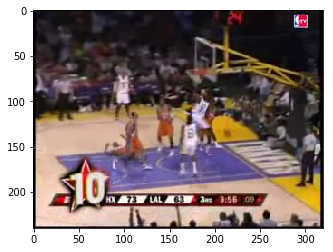

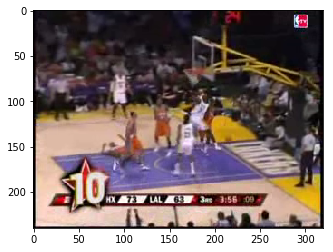

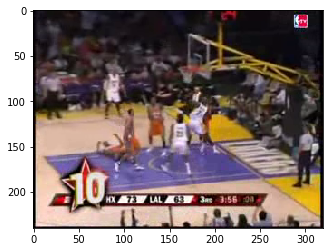

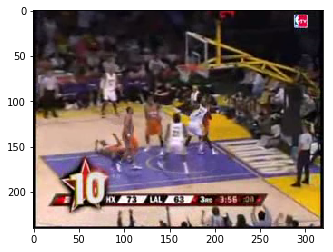

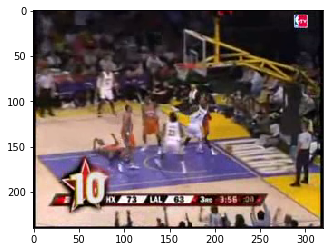

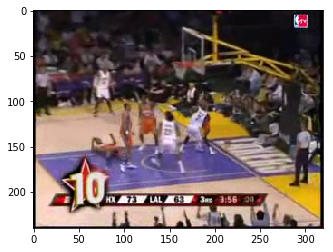

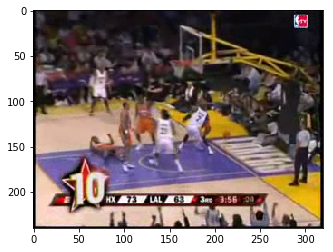

In [174]:
for img in video_frames:
    plt.figure()
    plt.imshow(img/255)

In [ ]:
for start, end in zip(range(0, video_frames.shape[0] + batch_size, batch_size),
                      range(batch_size, video_frames.shape[0] + batch_size, batch_size)):
    

ValueError: var_list cannot be empty